# CSE 6367 Programming Assignment 2 (P2)

## Fall 2023

### Task 1 (30 points) 

Implement Hough transform to detect lines in the image. Superimpose detected lines on the original image.

Note: You shouldn't use cv2.HoughCircles() or any other library fuctions to detect the circles.

<img src = Images/lines.jpg>

### Hough line transform

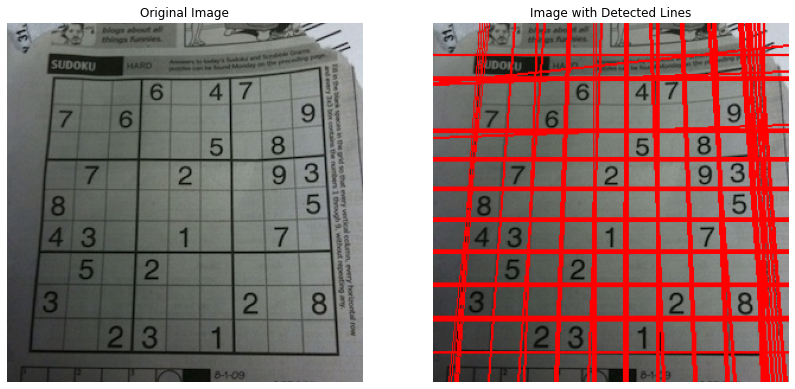

In [1]:
#import all libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

#user define hough line transform
def hough_line_tranform(image):
    
    #convert original image into grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply canny edge detector from cv2, used 50,150 threshold for detecting all the lines
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Create a Hough accumulator
    #θ = π , theta_max=π ,theta_min = -π
    height, width = edges.shape
    diagonal_len = int(np.sqrt(height**2 + width**2))
    rho_max = diagonal_len
    rho_min = -rho_max
    theta_max = np.pi
    theta_min = -theta_max
    num_rho = diagonal_len * 2
    num_theta = 180  

    # Initialize the Hough accumulator matrix
    accumulator_matrix = np.zeros((num_rho, num_theta), dtype=np.uint64)

    # Define the delta_rho and delta_theta
    delta_rho = (rho_max - rho_min) / num_rho
    delta_theta = (theta_max - theta_min) / num_theta

    # Detect lines in the image
    for y in range(height):
        for x in range(width):
            if edges[y, x] > 0:
                for theta_indx in range(num_theta):
                    theta = (theta_min + (theta_indx * delta_theta))
                    rho = x * np.cos(theta) + y * np.sin(theta)
                    rho_indx = int((rho - rho_min) / delta_rho)
                    accumulator_matrix[rho_indx, theta_indx] += 1

    # Set a threshold for line detection
    threshold = 100

    # Find the indices of accumulator cells above the threshold
    rho_indx, theta_indx = np.where(accumulator_matrix > threshold)

    # Create a copy of the original image to draw lines on
    result_image = image.copy()

    # Draw the detected lines on the image
    for rho_index, theta_index in zip(rho_indx, theta_indx):
        rho_value = rho_min + rho_index * delta_rho
        theta_value = theta_min + theta_index * delta_theta
        a = np.cos(theta_value)
        b = np.sin(theta_value)
        x = a * rho_value
        y = b * rho_value
        length_line = 1000 # Length of the line
        x1 = int(x + length_line * (-b))
        y1 = int(y + length_line * (a))
        x2 = int(x - length_line * (-b))
        y2 = int(y - length_line * (a))
        cv2.line(result_image, (x1, y1), (x2, y2), (0,0, 255), 1)
    return result_image

# Load the image
image = cv2.imread('./Images/lines.jpg')
result=hough_line_tranform(image)

# Display the original image and the image with detected lines
plt.figure(figsize=(14,12))
plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Image with Detected Lines")
plt.axis('off')

plt.show()


### Task 2 (30 points) 

Implement Hough transform from scratch to detect circles in the image. Refer to this wiki page for pseudocode(https://en.wikipedia.org/wiki/Circle_Hough_Transform). Superimpose detected circles on the original image.

Note: You shouldn't use cv2.HoughCircles() or any other library fuctions to detect the circles.

<img src = Images/circles.jpg>

### Hough circle transform

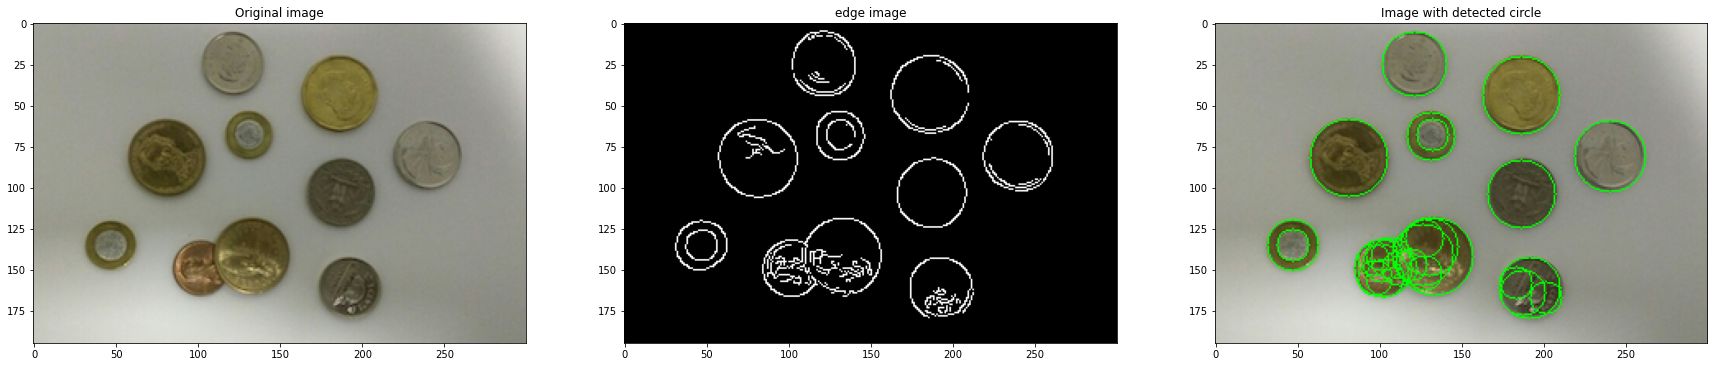

In [2]:
# import all libraries
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict

def Hough_circle_detection(image, edge_image, r_min, r_max, delta_r, num_thetas, threshold, post_process = True):
    height, width = edge_image.shape[:2]
    dtheta = int(360 / num_thetas)
    #theta value from 0 to 360
    thetas = np.arange(0, 360, step=dtheta)
    #Radius ranges min to max 
    radius_range = np.arange(r_min, r_max, step=delta_r)
    
    #Calculate Cosθ and Sinθ 
    cosθ = np.cos(np.deg2rad(thetas))
    sinθ = np.sin(np.deg2rad(thetas))
    circle_candidates_matrix = []
    for r in radius_range:
        for t in range(num_thetas):
            circle_candidates_matrix.append((r, int(r * cosθ[t]), int(r * sinθ[t])))

    #calculate accumulator matrix
    accumulator = defaultdict(int)
    for y in range(height):
        for x in range(width):
            if edge_image[y][x] != 0: 
                for r, rcos_t, rsin_t in circle_candidates_matrix:
                    center_x = x - rcos_t
                    center_y = y - rsin_t
                    accumulator[(center_x, center_y, r)] += 1 

    #Output image with detected lines and Output list of detected circles 
    output_image = image.copy()
    output_circles = []
  
    #for the candidate circles,Sort the accumulator matruix based on the votes  
    for candidate_circle, votes in sorted(accumulator.items(), key=lambda i: -i[1]):
        x, y, r = candidate_circle
        current_vote = votes / num_thetas
        if current_vote >= threshold: 
          #Shortlist the circles for final image
            output_circles.append((x, y, r, current_vote))

    #Post process the results
    if post_process:
        pixel_threshold = 4
        processed_circles = []
        for x, y, r, v in output_circles:
            if all(abs(x - xc) > pixel_threshold or abs(y - yc) > pixel_threshold or abs(r - rc) > pixel_threshold for xc, yc, rc, v in processed_circles):
                processed_circles.append((x, y, r, v))
    output_circles = processed_circles
    #Draw circles on the input image
    for x, y, r, v in output_circles:
        output_img = cv2.circle(output_image, (x,y), r, (0,255,0), 1)
    return output_image, output_circles



#load the images
input_image = cv2.imread('./Images/circles.jpg')
#convert original image to grayscale image
grayscale_img = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
#apply edge detection Canny function for detecting the edge
min_threshold = 100
max_threshold = 200
edge_image = cv2.Canny(grayscale_img, min_threshold, max_threshold)
#call user defined hough circel function
r_min = 10
r_max = 100
delta_r = 1
num_theta = 100
threshold = 0.4
circle_img, circles = Hough_circle_detection(input_image, edge_image, r_min, r_max, delta_r, num_theta, threshold)


# Display the original image and the image with detected circles
plt.figure(figsize=(30,30))

plt.subplot(1,3,1);
plt.title("Original image");
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,2);
plt.title("edge image");
plt.imshow(cv2.cvtColor(edge_image, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,3);
plt.title("Image with detected circle");
plt.imshow(cv2.cvtColor(circle_img, cv2.COLOR_BGR2RGB))
plt.show()

### Task 3 (40 points)

Implement Harris corner detector from scratch. Mark detected corners on original image. 

Note: You shouldn't use cv2.cornerHarris() or any other library functions to detect the corners.

<img src = Images/corners.jpg>

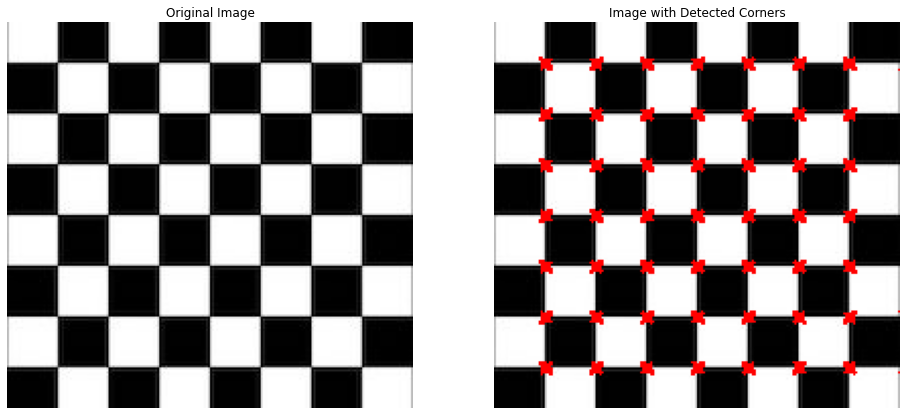

In [3]:
#import all libraries
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

#user_define function for harris corner detection:
def harris_corner_detector(image, threshold=0.01, block_size=4):
    # Step 01 convert original image into graysclae image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Compute gradients by using Sobel operator
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)

    # Step 3: Compute the elements Ixx, Iyy and Iyy
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy
    
    # Step 4: Compute window size , Sxx, Syy and Sxy
    window = np.ones((block_size, block_size), np.float32)
    Sxx = cv2.filter2D(Ixx, -1, window)
    Sxy = cv2.filter2D(Ixy, -1, window)
    Syy = cv2.filter2D(Iyy, -1, window)
    
    #k is an emppirically determined constant; k=0.04−0.06, here we use 0.04
    # Step 5: Compute the determinant, trace and score R using eigenvalues

    k=0.04
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    # Step 6: Finding the corner point using threshold and R.max()
    corner_points = np.zeros_like(R)
    corner_points[R > threshold * R.max()] = 255

    # Step 7: Mark detected corners on the original image
    image_corners = image.copy()
    image_corners[corner_points > 0] = [0, 0, 255]  # Red color for corners
    return image_corners

# Load an image
image = cv2.imread('./Images/corners.jpg')
# Detect corners using the user define Harris Corner Detector function
result = harris_corner_detector(image)

#Plot the original image and the image with detected corners using Matplotlib
plt.figure(figsize=(16, 10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Image with Detected Corners")
plt.axis('off')
plt.show()

## Submission Guidelines:

    Submit through Canvas your source code in a single .ipynb file. The name of the .ipynb file should be YourStudentID.ipynb. (For example: 1001234567.ipynb)
    Import all the images from the ./Images directory. Your TA will use the same directory name to grade your submission.
    You don't need to attach the image file with your submission.
